In [92]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import texthero as hero
from texthero import preprocessing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

In [32]:
cols_4 = ['EventDescription', 'IncidentCause', 'IncidentConsequence', 'FailedAssets','Category']
cols_9 = ['EventDescription', 'ActionTaken', 'IncidentCause', 'IncidentConsequence', 'CauseCommunity', 'FailedAssets', 'CauseWorkP', 'CauseTechnical', 'CauseEnvironment', 'Category']

In [34]:
df = pd.read_csv('cleaned_incidents1.csv', usecols = cols_9)

# filling up missing values
df = df.dropna(axis=0, subset=['Category'])
df = df.replace(np.nan, '', regex=True)

In [85]:
df['description_4'] = ''
df['description_9'] = ''

tot_cols = len(cols_4)-1 # not include category
for i in range(tot_cols):  
    df['description_4'] = df['description_4'] + ' ' + df[cols_4[i]]
    
tot_cols = len(cols_9)-1 # not include category
for i in range(tot_cols):
    df['description_9'] = df['description_9'] + ' ' + df[cols_9[i]]

In [86]:
df['description_4'] = hero.clean(df['description_4'])
df['description_9'] = hero.clean(df['description_9'])

In [87]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10,use_idf= True) #using only unigrams for tfidf
tf_idf_vect.fit(df['description_9'])
final_tf_idf_4 = tf_idf_vect.transform(df['description_4'])
final_tf_idf_9 = tf_idf_vect.transform(df['description_9'])

In [69]:
def truncate_components(n_cols, n_comp, final_tf_idf, new_rows):
    explained = [] # explained variance ratio for each component of Truncated SVD
    for x in n_comp:
        svd = TruncatedSVD(n_components=x)
        final = svd.fit_transform(final_tf_idf)
       
        x_train, x_test, y_train, y_test = train_test_split(final,Y, test_size=0.25, random_state=4, stratify = Y)

        # balance the data - optional
        oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5)
        x_train, y_train = oversample.fit_resample(x_train, y_train)

        # classification - SGD
        sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
        sgd.fit(x_train, y_train)
        y_pred = sgd.predict(x_test)
        sgd_accuracy = accuracy_score(y_test,y_pred)
        
        #classification - SVM
        svc = SVC(C=1.0, kernel = 'linear')
        svc.fit(x_train, y_train)
        y_pred = svc.predict(x_test)
        svm_accuracy = accuracy_score(y_test,y_pred)
        
        # classification - random forest
        rf = RandomForestClassifier(random_state=44)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        rf_accuracy = accuracy_score(y_test,y_pred)

        new_row = [n_cols, x, sgd_accuracy,svm_accuracy, rf_accuracy]
        new_rows.append(new_row)

        print('methods: {} num of components {} accuracy {}'.format(x, 'SGD', sgd_accuracy))
        print('methods: {} num of components {} accuracy {}'.format(x, 'SVM', svm_accuracy))
        print('methods: {} num of components {} accuracy {}'.format(x, 'RF', rf_accuracy))
        
    return new_rows

In [113]:
# EXPERIMENTS

le = LabelEncoder()
Y = le.fit_transform(df['Category'])

accuracy_df = pd.DataFrame()
    
new_rows = []

n_comp = [1000, 1500, 2200]

# SELECT functions you want to test

n_features_4 = final_tf_idf_4.shape[1]
new_rows = truncate_components(4, n_comp, final_tf_idf_4, new_rows)

n_features_9 = final_tf_idf_9.shape[1]
new_rows = truncate_components(9, n_comp, final_tf_idf_9, new_rows)

accuracy_df = pd.DataFrame(new_rows, columns=['n_cols','n_components', 'sgd', 'svm', 'rf'])

accuracy_df.to_csv('truncated_accuracy_ML.csv', index=False)

methods: 2200 num of components SGD accuracy 0.8065311152187308
methods: 2200 num of components SVM accuracy 0.8379544054220579
methods: 2200 num of components RF accuracy 0.7356746765249538
methods: 2200 num of components SGD accuracy 0.8139248305606901
methods: 2200 num of components SVM accuracy 0.8422674060382008
methods: 2200 num of components RF accuracy 0.7547751078250154


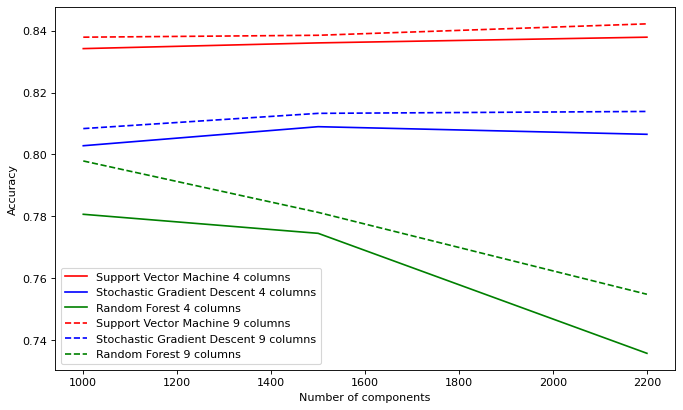

In [117]:
# retrieve from ds if object is no longer exist
accuracy_df = pd.read_csv('truncated_accuracy_ML.csv')

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

accuracy_df_4 = accuracy_df.loc[accuracy_df['n_cols'] == 4]
accuracy_df_9 = accuracy_df.loc[accuracy_df['n_cols'] == 9]

x = accuracy_df_4.n_components

y1 = accuracy_df_4[['svm']]
plt.plot(x, y1, label = "Support Vector Machine 4 columns", color='red')

y2 = accuracy_df_4[['sgd']]
plt.plot(x, y2, label = "Stochastic Gradient Descent 4 columns", color='blue')

y3 = accuracy_df_4[['rf']]
plt.plot(x, y3, label = "Random Forest 4 columns", color='green')

y4 = accuracy_df_9[['svm']]
plt.plot(x, y4, label = "Support Vector Machine 9 columns", color='red', linestyle='--')

y5 = accuracy_df_9[['sgd']]
plt.plot(x, y5, label = "Stochastic Gradient Descent 9 columns", color='blue', linestyle='--')

y6 = accuracy_df_9[['rf']]
plt.plot(x, y6, label = "Random Forest 9 columns", color='green', linestyle='--')

plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Conclusion from the experiments:
- Using 9 columns achieves slightly better accuracy
- In SVM, more components achieves slightly better accuracy
- In SGD, with 1500 components, achieves the highest accuracy
- In RF, more components, the lower the accuracy. 